# Nodal Analysis Solver
**Objective:** Mathematically solve for the well's Operating Point (Flow Rate and Bottomhole Pressure).
**Author:** Ade Anggi Naluriawan Santoso

In the previous notebooks, we calculated IPR and TPR independently. 
* **IPR:** Represents the Reservoir's energy (Supply).
* **TPR:** Represents the Piping system's energy loss (Demand).

The **Operating Point** is the flow rate ($q_{op}$) where Supply = Demand:
$$P_{wf, IPR}(q) = P_{wf, TPR}(q)$$

In this notebook, we will:
1. Define an **Inverse IPR** function (calculate Pressure from Rate).
2. Define a **Residual Function** (Supply - Demand).
3. Use `scipy.optimize` to find the exact intersection.
4. Perform a **Sensitivity Analysis** (e.g., changing Tubing Size).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Defining the Models (Recap)
To solve the system, we need functions that return **Pressure ($P_{wf}$)** given a **Rate ($q$)**.

### Inverse Vogel's Equation
Standard Vogel calculates Rate from Pressure. We need the reverse:
$$0.8 \left(\frac{P_{wf}}{P_r}\right)^2 + 0.2 \left(\frac{P_{wf}}{P_r}\right) + \left(\frac{q}{q_{max}} - 1\right) = 0$$
We solve this quadratic equation for $P_{wf}$.

In [2]:
def get_ipr_pressure(q, p_res, q_max):
    """
    Inverse Vogel: Calculates Pwf given a flow rate q.
    Returns P_res if q is 0. 
    Returns 0 if q >= q_max.
    """
    if q >= q_max:
        return 0.0
    if q <= 0:
        return p_res
        
    # y = q / q_max
    y = q / q_max
    
    # Quadratic form: ax^2 + bx + c = 0
    # 0.8x^2 + 0.2x + (y - 1) = 0
    # where x = P_wf / P_res
    
    a = 0.8
    b = 0.2
    c = y - 1
    
    # Quadratic formula: x = (-b + sqrt(b^2 - 4ac)) / 2a
    # We take the positive root for pressure
    delta = b**2 - 4*a*c
    
    if delta < 0: return 0 # Should not happen if q < q_max
    
    x = (-b + np.sqrt(delta)) / (2*a)
    
    return x * p_res

### Simplified TPR Model
We will use a simplified correlation for the TPR (Tubing Performance) to keep this notebook fast. In a production app, you would import the rigorous "Marching Algorithm" we built in Notebook 03.

In [3]:
def get_tpr_pressure(q, p_wh, depth, tubing_id):
    """
    Simplified TPR model for demonstration.
    P_wf = P_wh + Hydrostatic + Friction
    """
    # 1. Hydrostatic (Simplified Gradient ~ 0.3 psi/ft for mixed fluid)
    # As rate increases, liquid hold up decreases, so gradient lightens slightly
    # This is a 'dummy' correlation to mimic physics
    grad_elev = 0.35 - (0.00002 * q) 
    p_hydro = depth * grad_elev
    
    # 2. Friction (Proportional to q^2 / d^5)
    # C is a friction coefficient
    C = 2.0e-5
    p_friction = C * (q ** 2) * (depth / 1000) / (tubing_id ** 5)
    
    return p_wh + p_hydro + p_friction

## 2. The Nodal Solver
We want to find $q$ where:
$$Residual(q) = P_{IPR}(q) - P_{TPR}(q) = 0$$

We use **`scipy.optimize.brentq`**, a robust root-finding method. It requires a bracket (an interval $[a, b]$ where the sign of the function changes).
* Lower bound $a$: 0.1 stb/d
* Upper bound $b$: $q_{max}$ (AOF)

In [4]:
def nodal_solver(p_res, q_max, p_wh, depth, tubing_id):
    """
    Finds the intersection of IPR and TPR.
    """
    
    # Define the residual function
    def residual(q):
        p_supply = get_ipr_pressure(q, p_res, q_max)
        p_demand = get_tpr_pressure(q, p_wh, depth, tubing_id)
        return p_supply - p_demand

    # Check for solution existence
    # At q=0, Supply (P_res) should be > Demand (P_wh + Hydrostatic) to flow naturally
    if residual(0.1) < 0:
        return 0.0, 0.0, "Dead Well (Insufficient Pressure)"
    
    # Find root between 0.1 and q_max
    try:
        q_sol = brentq(residual, 0.1, q_max)
        p_sol = get_ipr_pressure(q_sol, p_res, q_max)
        return q_sol, p_sol, "Flowing"
    except ValueError:
        return 0.0, 0.0, "No Intersection (Demand > Supply)"

# --- RUN THE SOLVER ---
# Well Inputs
well_data = {
    'p_res': 3500,     # psia
    'q_max': 5000,     # stb/d (AOF)
    'p_wh': 200,       # psia
    'depth': 8000,     # ft
    'tubing_id': 2.441 # inches (2-7/8" tubing)
}

q_op, p_op, status = nodal_solver(**well_data)

print(f"Status: {status}")
print(f"Operating Rate: {q_op:.2f} stb/d")
print(f"Bottomhole Flowing Pressure: {p_op:.2f} psia")

Status: Flowing
Operating Rate: 1816.39 stb/d
Bottomhole Flowing Pressure: 2715.47 psia


## 3. Sensitivity Analysis: Tubing Size Optimization
One of the main uses of Nodal Analysis is selecting the right tubing size.
* **Too small:** High friction limits rate.
* **Too large:** Liquid loading (fluid falls back) kills the well (though our simple model mainly shows friction effects).

Let's compare three standard tubing sizes:
1. **2-3/8"** (ID ~ 1.995")
2. **2-7/8"** (ID ~ 2.441")
3. **3-1/2"** (ID ~ 2.992")

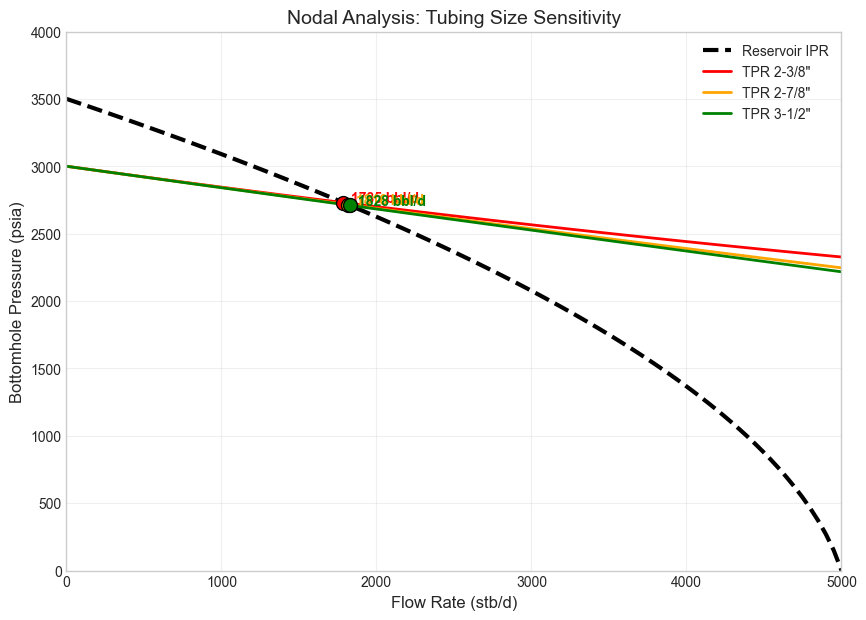

In [5]:
tubing_sizes = [
    (1.995, '2-3/8"'),
    (2.441, '2-7/8"'),
    (2.992, '3-1/2"')
]

plt.figure(figsize=(10, 7))

# 1. Plot IPR (Supply) - Constant for all tubing sizes
q_space = np.linspace(0, well_data['q_max'], 100)
p_ipr = [get_ipr_pressure(q, well_data['p_res'], well_data['q_max']) for q in q_space]
plt.plot(q_space, p_ipr, label='Reservoir IPR', color='black', linewidth=3, linestyle='--')

# 2. Plot TPRs (Demand) for each size
colors = ['red', 'orange', 'green']

for (tid, name), color in zip(tubing_sizes, colors):
    # Calculate Curve
    p_tpr = [get_tpr_pressure(q, well_data['p_wh'], well_data['depth'], tid) for q in q_space]
    plt.plot(q_space, p_tpr, label=f'TPR {name}', color=color, linewidth=2)
    
    # Calculate Intersection
    q_s, p_s, _ = nodal_solver(well_data['p_res'], well_data['q_max'], well_data['p_wh'], well_data['depth'], tid)
    
    # Plot Dot
    if q_s > 0:
        plt.scatter(q_s, p_s, s=100, color=color, edgecolors='black', zorder=10)
        plt.text(q_s+50, p_s, f"{q_s:.0f} bbl/d", fontsize=10, fontweight='bold', color=color)

plt.title("Nodal Analysis: Tubing Size Sensitivity", fontsize=14)
plt.xlabel("Flow Rate (stb/d)", fontsize=12)
plt.ylabel("Bottomhole Pressure (psia)", fontsize=12)
plt.ylim(0, well_data['p_res'] + 500)
plt.xlim(0, well_data['q_max'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()